<a href="https://colab.research.google.com/github/tmbern/DS-Unit-1-Build/blob/master/NFL_Spreads_%26_Totals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# How good are NFL spread and Totals

### Read In the Data Set and preform preliminary cleaning

  Drop some rows/columns

  Fill NaN values

In [2]:
## Read in data set to pandas dataframe

df_NFL_spread = pd.read_csv('/content/nfl.csv')

df_NFL_spread.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Home Odds Min,Home Odds Max,Home Odds Close,Away Odds Open,Away Odds Min,Away Odds Max,Away Odds Close,Home Line Open,Home Line Min,Home Line Max,Home Line Close,Away Line Open,Away Line Min,Away Line Max,Away Line Close,Home Line Odds Open,Home Line Odds Min,Home Line Odds Max,Home Line Odds Close,Away Line Odds Open,Away Line Odds Min,Away Line Odds Max,Away Line Odds Close,Total Score Open,Total Score Min,Total Score Max,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Notes
0,2/2/2020,Kansas City Chiefs,San Francisco 49ers,31,20,NaN,Y,Y,1.80,1.80,1.83,1.80,2.05,2.00,2.05,2.05,-1.5,-1.5,-1.0,-1.5,1.5,1.0,1.5,1.5,1.90,1.90,1.90,1.9,1.90,1.90,1.90,1.90,53.0,53.0,54.0,53.0,1.9,1.9,1.90,1.9,1.9,1.9,1.9,1.9,NaN
1,1/19/2020,San Francisco 49ers,Green Bay Packers,37,20,NaN,Y,NaN,1.31,1.26,1.31,1.26,3.55,3.55,4.00,4.00,-7.0,-8.0,-7.0,-8.0,7.0,7.0,8.0,8.0,1.90,1.86,1.95,1.9,1.90,1.86,1.95,1.90,45.0,45.0,46.5,46.5,1.9,1.9,1.90,1.9,1.9,1.9,1.9,1.9,NaN
2,1/19/2020,Kansas City Chiefs,Tennessee Titans,35,24,NaN,Y,NaN,1.29,1.28,1.31,1.28,3.70,3.60,3.75,3.75,-7.5,-7.5,-7.0,-7.0,7.5,7.0,7.5,7.0,1.90,1.90,1.90,1.9,1.90,1.90,1.90,1.90,51.0,51.0,53.0,51.0,1.9,1.9,1.90,1.9,1.9,1.9,1.9,1.9,NaN
3,1/12/2020,Green Bay Packers,Seattle Seahawks,28,23,NaN,Y,NaN,1.52,1.45,1.52,1.45,2.67,2.67,2.80,2.80,-3.5,-4.5,-3.5,-4.5,3.5,3.5,4.5,4.5,1.90,1.86,1.90,1.9,1.90,1.90,1.95,1.90,46.0,45.0,47.0,45.5,1.9,1.9,1.90,1.9,1.9,1.9,1.9,1.9,NaN
4,1/12/2020,Kansas City Chiefs,Houston Texans,51,31,NaN,Y,NaN,1.27,1.20,1.27,1.22,3.80,3.80,4.75,4.50,-8.0,-10.0,-8.0,-10.0,8.0,8.0,10.0,10.0,1.86,1.90,1.86,2.0,1.95,1.95,1.90,1.83,49.5,48.5,51.5,50.5,1.9,1.9,1.95,1.9,1.9,1.9,1.9,1.9,NaN


In [0]:
##Check for null values. May need to clean up. 
## There are a lot of nulls so will need to clean those

df_NFL_spread.isnull().sum()

In [0]:
#Cleaning null values

#overtime, playoff game, and neutral field null values should be coded to "N"
#overtime should be a Y or N

df_NFL_spread['Overtime?'] = df_NFL_spread['Overtime?'].fillna('N')
df_NFL_spread['Playoff Game?'] = df_NFL_spread['Playoff Game?'].fillna('N')
df_NFL_spread['Neutral Venue?'] = df_NFL_spread['Neutral Venue?'].fillna('N')


In [0]:
## Clean up Null values for lines, spread, odds, and total scores. 
## The opening away lines should be equal to the negative of the opening home lines as well as closing lines
## if there is no home closing line then we will set that equal to the home open line


df_NFL_spread['Away Line Open'].fillna(value=-df_NFL_spread['Home Line Open'], inplace=True)
df_NFL_spread['Away Line Close'].fillna(value=-df_NFL_spread['Home Line Open'], inplace=True)
df_NFL_spread['Home Line Close'].fillna(value=df_NFL_spread['Home Line Open'], inplace=True)
df_NFL_spread['Total Score Close'].fillna(value=df_NFL_spread['Total Score Open'], inplace=True)
df_NFL_spread['Home Odds Close'].fillna(value=df_NFL_spread['Home Odds Open'], inplace=True)
df_NFL_spread['Away Odds Close'].fillna(value=df_NFL_spread['Away Odds Open'], inplace=True)


In [0]:
# We dont have enough information from the data to fill NaN values for opening lines
# we will drop the columns that we will not be using. 

features_to_drop = ['Home Line Odds Open', 'Home Line Odds Min', 'Home Line Odds Max',
                    'Home Line Odds Close', 'Away Line Odds Open', 'Away Line Odds Min',
                    'Away Line Odds Max', 'Away Line Odds Close', 'Total Score Over Open',
                    'Total Score Over Min', 'Total Score Over Max', 'Total Score Over Close', 
                    'Total Score Under Open', 'Total Score Under Min', 'Total Score Under Max',
                    'Total Score Under Close', 'Notes', 'Home Odds Min', 'Home Odds Max', 'Away Odds Min',
                    'Away Odds Max', 'Home Line Max', 'Home Line Min', 'Away Line Min',
                    'Away Line Max', 'Total Score Min', 'Total Score Max']

df_NFL_cleaned = df_NFL_spread.drop(features_to_drop, axis=1)
df_NFL_cleaned 

In [7]:
## make sure that the home spread and away spread difference == 0

print(((df_NFL_cleaned['Home Line Close'] + df_NFL_cleaned['Away Line Close']) == 0).value_counts())

True    3738
dtype: int64


In [8]:
df_NFL_cleaned.isnull().sum()

Date                 0
Home Team            0
Away Team            0
Home Score           0
Away Score           0
Overtime?            0
Playoff Game?        0
Neutral Venue?       0
Home Odds Open       0
Home Odds Close      0
Away Odds Open       0
Away Odds Close      0
Home Line Open       0
Home Line Close      0
Away Line Open       0
Away Line Close      0
Total Score Open     0
Total Score Close    0
dtype: int64

###Want to change the date format and create some new features based on date. Because seasons go over different years we will need to bin the season by a cut off.

In [9]:
#want to change the date format to datetime

df_NFL_cleaned['Date'] = pd.to_datetime(df_NFL_cleaned['Date'], infer_datetime_format=True )
df_NFL_cleaned.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Home Odds Close,Away Odds Open,Away Odds Close,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Total Score Open,Total Score Close
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,1.80,1.80,2.05,2.05,-1.5,-1.5,1.5,1.5,53.0,53.0
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,1.31,1.26,3.55,4.00,-7.0,-8.0,7.0,8.0,45.0,46.5
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,1.29,1.28,3.70,3.75,-7.5,-7.0,7.5,7.0,51.0,51.0
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,1.52,1.45,2.67,2.80,-3.5,-4.5,3.5,4.5,46.0,45.5
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,1.27,1.22,3.80,4.50,-8.0,-10.0,8.0,10.0,49.5,50.5


In [44]:
# because seasons cross over years, we will want to create bins to signify what
# an observation is played in.
# use describe to get the min and max season

df_NFL_cleaned.describe(exclude='number')


,Date,Home Team,Away Team,Overtime?,Playoff Game?,Neutral Venue?,Season
count,3738,3738,3738,3738,3738,3738,3738
unique,740,34,34,2,2,2,14
top,2019-12-29 00:00:00,New England Patriots,Baltimore Ravens,N,N,N,Season 2019-2020
freq,16,133,125,3520,3584,3693,267
first,2006-09-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


The first game is played on **09/07/2006** and the last game in data is **02/02/2020**

Seasons start in august(preseason) and end in february(superbowl) we will use those as the bins and cutpoints

In [45]:
# create bins and cutpoints so that our season extends from August in one year and
# ends at august of the next year. 

bin_dates = pd.date_range(start='2005-09-01', end='2021-08-02', freq='A-AUG')
bin_labels = ['Season 2006-2007', 'Season 2007-2008', 'Season 2008-2009',
              'Season 2009-2010','Season 2010-2011', 'Season 2011-2012', 
              'Season 2012-2013', 'Season 2013-2014', 'Season 2014-2015',
              'Season 2015-2016', 'Season 2016-2017', 'Season 2017-2018',
              'Season 2018-2019', 'Season 2019-2020']

bin_dates

DatetimeIndex(['2006-08-31', '2007-08-31', '2008-08-31', '2009-08-31',
               '2010-08-31', '2011-08-31', '2012-08-31', '2013-08-31',
               '2014-08-31', '2015-08-31', '2016-08-31', '2017-08-31',
               '2018-08-31', '2019-08-31', '2020-08-31'],
              dtype='datetime64[ns]', freq='A-AUG')

In [0]:
#add a new column labeled 'Season' using the bins that we created above

df_NFL_cleaned['Season'] = pd.cut(df_NFL_cleaned['Date'], bin_dates, labels=bin_labels)


In [47]:
df_NFL_cleaned.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Home Odds Close,Away Odds Open,Away Odds Close,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Total Score Open,Total Score Close,Season
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,1.80,1.80,2.05,2.05,-1.5,-1.5,1.5,1.5,53.0,53.0,Season 2019-2020
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,1.31,1.26,3.55,4.00,-7.0,-8.0,7.0,8.0,45.0,46.5,Season 2019-2020
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,1.29,1.28,3.70,3.75,-7.5,-7.0,7.5,7.0,51.0,51.0,Season 2019-2020
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,1.52,1.45,2.67,2.80,-3.5,-4.5,3.5,4.5,46.0,45.5,Season 2019-2020
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,1.27,1.22,3.80,4.50,-8.0,-10.0,8.0,10.0,49.5,50.5,Season 2019-2020


### Create a couple more sub sets of data from the cleaned data so its easier to work with smaller subsets. we can always merge them if we need to

*  subset for spreads (home line and away line)  
* subset for total scores




In [48]:
## lets split dataset into three different data sets. 
## one being for spread(lines)
## another for total scores


#Cleaned Dataset for Spread/Lines
df_cleaned_spread = df_NFL_cleaned.drop(['Home Odds Close', 'Home Odds Open', 'Away Odds Open',
                                         'Away Odds Close', 'Total Score Open', 'Total Score Close'], axis=1)
df_cleaned_spread

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Season
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,-1.5,-1.5,1.5,1.5,Season 2019-2020
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,-7.0,-8.0,7.0,8.0,Season 2019-2020
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,-7.5,-7.0,7.5,7.0,Season 2019-2020
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,-3.5,-4.5,3.5,4.5,Season 2019-2020
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,-8.0,-10.0,8.0,10.0,Season 2019-2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,6.0,6.0,-6.0,-6.0,Season 2006-2007
3734,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,-3.0,-3.0,3.0,3.0,Season 2006-2007
3735,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,-4.5,-4.5,4.5,4.5,Season 2006-2007
3736,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,-9.5,-9.5,9.5,9.5,Season 2006-2007


In [49]:
#Cleaned Dataset for Total scores

df_cleaned_Score_Totals = df_NFL_cleaned.drop(['Home Odds Close', 'Home Odds Open', 'Away Odds Open',
                                         'Away Odds Close', 'Home Line Open', 'Home Line Close',
                                         'Away Line Open', 'Away Line Close'], axis=1)
df_cleaned_Score_Totals

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Total Score Open,Total Score Close,Season
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,53.0,53.0,Season 2019-2020
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,45.0,46.5,Season 2019-2020
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,51.0,51.0,Season 2019-2020
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,46.0,45.5,Season 2019-2020
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,49.5,50.5,Season 2019-2020
...,...,...,...,...,...,...,...,...,...,...,...
3733,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,44.0,44.0,Season 2006-2007
3734,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,36.5,36.5,Season 2006-2007
3735,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,38.5,38.5,Season 2006-2007
3736,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,43.5,43.5,Season 2006-2007


In [0]:
## Didnt end up using this data set so commenting out. 

# #Cleaned Dataset for Odds

# df_cleaned_home_away_odds = df_NFL_cleaned.drop(['Home Line Open', 'Home Line Close',
#                                                  'Away Line Open', 'Away Line Close',
#                                                  'Total Score Open', 'Total Score Close'], axis=1)
# df_cleaned_home_away_odds

### Feature Engineer on the Spread Subset of Data 

Add new columns to the spread dataset to show:  
* whether the home or the away team is the favorite
* whether the game was a pickem  
* Show whether the home or the away team covered the spread  
* show whether the game pushed  
* show whether the favorite or the underdog covered the spread  
* show whether the road favorite, road dog, home favorite, or home dog covered the spread

In [52]:
## If the Home line is less than 0 then the Home team is Favorite.
## If the Away line is less than 0 then the Away team is Favorite. 
## If the line is == to 0 than the game is a pick em. 

df_cleaned_spread.loc[df_cleaned_spread['Home Line Close'] < 0, 'Home is Favorite'] = 1
df_cleaned_spread.loc[df_cleaned_spread['Home Line Close'] >= 0, 'Home is Favorite'] = 0

df_cleaned_spread.loc[df_cleaned_spread['Away Line Close'] < 0, 'Away is Favorite'] = 1
df_cleaned_spread.loc[df_cleaned_spread['Away Line Close'] >= 0, 'Away is Favorite'] = 0

df_cleaned_spread.loc[df_cleaned_spread['Away Line Close'] == 0, 'Spread is pick em'] = 1
df_cleaned_spread.loc[df_cleaned_spread['Away Line Close'] != 0, 'Spread is pick em'] = 0


df_cleaned_spread.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Season,Home is Favorite,Away is Favorite,Spread is pick em
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,-1.5,-1.5,1.5,1.5,Season 2019-2020,1.0,0.0,0.0
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,-7.0,-8.0,7.0,8.0,Season 2019-2020,1.0,0.0,0.0
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,-7.5,-7.0,7.5,7.0,Season 2019-2020,1.0,0.0,0.0
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,-3.5,-4.5,3.5,4.5,Season 2019-2020,1.0,0.0,0.0
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,-8.0,-10.0,8.0,10.0,Season 2019-2020,1.0,0.0,0.0


#### Add new features to indicate whether the Home team or the away team covered the line(spread) or if the game was a push (that neither the home or away team covered the line)

In [54]:
## If the Home score + the home line - the away score is greater than 0 than the home team covers
## If the away score + the away line - the home score is greater than 0 than the away team covers
## If the difference between the scores + the line is equal to zero then the game is a push and niether covers




df_cleaned_spread.loc[(df_cleaned_spread['Home Score'] + df_cleaned_spread['Home Line Close'] - df_cleaned_spread['Away Score']) > 0, 'Home_Covers_Spread'] = 1
df_cleaned_spread.loc[(df_cleaned_spread['Home Score'] + df_cleaned_spread['Home Line Close'] - df_cleaned_spread['Away Score']) < 0, 'Home_Covers_Spread'] = 0

df_cleaned_spread.loc[(df_cleaned_spread['Away Score'] + df_cleaned_spread['Away Line Close'] - df_cleaned_spread['Home Score']) > 0, 'Away_Covers_Spread'] = 1
df_cleaned_spread.loc[(df_cleaned_spread['Away Score'] + df_cleaned_spread['Away Line Close'] - df_cleaned_spread['Home Score']) < 0, 'Away_Covers_Spread'] = 0

df_cleaned_spread.loc[(df_cleaned_spread['Away Score'] + df_cleaned_spread['Away Line Close'] - df_cleaned_spread['Home Score']) == 0, 'Game_is_push'] = 1
df_cleaned_spread.loc[(df_cleaned_spread['Away Score'] + df_cleaned_spread['Away Line Close'] - df_cleaned_spread['Home Score']) != 0, 'Game_is_push'] = 0

df_cleaned_spread.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Season,Home is Favorite,Away is Favorite,Spread is pick em,Home_Covers_Spread,Away_Covers_Spread,Game_is_push
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,-1.5,-1.5,1.5,1.5,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,-7.0,-8.0,7.0,8.0,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,-7.5,-7.0,7.5,7.0,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,-3.5,-4.5,3.5,4.5,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,-8.0,-10.0,8.0,10.0,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0


In [20]:
## Make a few more columns to show if favorites or underdogs covered the spread.
## If column home is favorite or away is favorite == 1 & Home_covers or Away_covers
## Then that means the favorite covered the sepread. 

df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 1) & (df_cleaned_spread['Home_Covers_Spread'] == 1)) |
                      ((df_cleaned_spread['Away is Favorite'] == 1) & (df_cleaned_spread['Away_Covers_Spread'] == 1)) , 'Favorite_Covers_Spread'] = 1

df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 0) & (df_cleaned_spread['Home_Covers_Spread'] == 1)) |
                      ((df_cleaned_spread['Away is Favorite'] == 0) & (df_cleaned_spread['Away_Covers_Spread'] == 1)) , 'Favorite_Covers_Spread'] = 0



df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 0) & (df_cleaned_spread['Home_Covers_Spread'] == 1)) |
                      ((df_cleaned_spread['Away is Favorite'] == 0) & (df_cleaned_spread['Away_Covers_Spread'] == 1)) , 'Underdog_Covers_Spread'] = 1

df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 1) & (df_cleaned_spread['Home_Covers_Spread'] == 1)) |
                      ((df_cleaned_spread['Away is Favorite'] == 1) & (df_cleaned_spread['Away_Covers_Spread'] == 1)) , 'Underdog_Covers_Spread'] = 0


## Column indicating if the Home Favorite covered the spread
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 1) & (df_cleaned_spread['Home_Covers_Spread'] == 1)), 'home_favorite_covers'] = 1
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 1) & (df_cleaned_spread['Home_Covers_Spread'] == 0)), 'home_favorite_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 0) & (df_cleaned_spread['Home_Covers_Spread'] == 1)), 'home_favorite_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 0) & (df_cleaned_spread['Home_Covers_Spread'] == 0)), 'home_favorite_covers'] = 0

## Column indicating if the Home Underdog covered the spread
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 0) & (df_cleaned_spread['Home_Covers_Spread'] == 1)), 'home_underdog_covers'] = 1
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 0) & (df_cleaned_spread['Home_Covers_Spread'] == 0)), 'home_underdog_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 1) & (df_cleaned_spread['Home_Covers_Spread'] == 1)), 'home_underdog_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Home is Favorite'] == 1) & (df_cleaned_spread['Home_Covers_Spread'] == 0)), 'home_underdog_covers'] = 0


# Column indicating if the Away Favorite covered the spread
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 1) & (df_cleaned_spread['Away_Covers_Spread'] == 1)), 'away_favorite_covers'] = 1
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 1) & (df_cleaned_spread['Away_Covers_Spread'] == 0)), 'away_favorite_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 0) & (df_cleaned_spread['Away_Covers_Spread'] == 1)), 'away_favorite_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 0) & (df_cleaned_spread['Away_Covers_Spread'] == 0)), 'away_favorite_covers'] = 0


# Column indicating if the Away Underdog covered the spread
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 0) & (df_cleaned_spread['Away_Covers_Spread'] == 1)), 'away_underdog_covers'] = 1
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 0) & (df_cleaned_spread['Away_Covers_Spread'] == 0)), 'away_underdog_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 1) & (df_cleaned_spread['Away_Covers_Spread'] == 1)), 'away_underdog_covers'] = 0
df_cleaned_spread.loc[((df_cleaned_spread['Away is Favorite'] == 1) & (df_cleaned_spread['Away_Covers_Spread'] == 0)), 'away_underdog_covers'] = 0

print(df_cleaned_spread.shape)
df_cleaned_spread                    


(3738, 25)


,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Line Open,Home Line Close,Away Line Open,Away Line Close,Season,Home is Favorite,Away is Favorite,Spread is pick em,Home_Covers_Spread,Away_Covers_Spread,Game_is_push,Favorite_Covers_Spread,Underdog_Covers_Spread,home_favorite_covers,home_underdog_covers,away_favorite_covers,away_underdog_covers
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,-1.5,-1.5,1.5,1.5,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,-7.0,-8.0,7.0,8.0,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,-7.5,-7.0,7.5,7.0,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,-3.5,-4.5,3.5,4.5,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,-8.0,-10.0,8.0,10.0,Season 2019-2020,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,6.0,6.0,-6.0,-6.0,Season 2006-2007,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3734,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,-3.0,-3.0,3.0,3.0,Season 2006-2007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3735,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,-4.5,-4.5,4.5,4.5,Season 2006-2007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3736,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,-9.5,-9.5,9.5,9.5,Season 2006-2007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [21]:
#What is the accuracy of picking Favorites to cover the spread


print('Favorite % against the spread: ', (df_cleaned_spread['Favorite_Covers_Spread'] == 1).value_counts()[1] / df_cleaned_spread.shape[0])
print('Underdog % against the spread: ', (df_cleaned_spread['Underdog_Covers_Spread'] == 1).value_counts()[1] / df_cleaned_spread.shape[0])
print('% of games that pushed: ', (df_cleaned_spread['Game_is_push'] == 1).value_counts()[1] / df_cleaned_spread.shape[0])


Favorite % against the spread:  0.4668271803103264
Underdog % against the spread:  0.5048154093097913
% of games that pushed:  0.02835741037988229


### Now that we have all the inputs lets create a prettier data Frame to better visualize the data. 

In [0]:
## make dataframe that lists all season in the rows and the variables will be
## total wins for favorites, underdogs, and games that were pushes

seasons = df_cleaned_spread['Season'].unique()
empty_list =[]

for season in seasons:
  temp = pd.DataFrame({'season': [season],
   'favorite_wins': [((df_cleaned_spread['Favorite_Covers_Spread'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]],
   'underdog_wins': [((df_cleaned_spread['Underdog_Covers_Spread'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]],
   'game_pushed': [((df_cleaned_spread['Game_is_push'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]],
   'home_favorite_wins': [((df_cleaned_spread['home_favorite_covers'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]],
   'road_underdog_wins': [((df_cleaned_spread['away_underdog_covers'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]],
   'home_underdog_wins': [((df_cleaned_spread['home_underdog_covers'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]],
   'road_favorite_wins': [((df_cleaned_spread['away_favorite_covers'] == 1) & (df_cleaned_spread['Season'] == season)).value_counts()[1]]})
  empty_list.append(temp)

df_season_records = pd.concat(empty_list, join='outer')

df_season_records['Total Games'] = df_season_records['favorite_wins'] + df_season_records['underdog_wins'] + df_season_records['game_pushed']



In [23]:
#Make columns that show the win % for favorite, underdogs, and games that pushed

df_season_records['favorite_win_%'] = round((df_season_records['favorite_wins'] / df_season_records['Total Games']), 4)
df_season_records['underdog_win_%'] = round((df_season_records['underdog_wins'] / df_season_records['Total Games']), 4)
df_season_records['push%'] = round((df_season_records['game_pushed'] / df_season_records['Total Games']), 4)
df_season_records['Total percent'] = round((df_season_records['favorite_win_%'] + df_season_records['underdog_win_%'] + df_season_records['push%']),0)
df_season_records['road_dog_win_%'] = round((df_season_records['road_underdog_wins'] / (df_season_records['road_underdog_wins'] + df_season_records['home_favorite_wins'])), 4)
df_season_records['home_favorite_win_%'] = round(1 - df_season_records['road_dog_win_%'], 4)
df_season_records['home_dog_win_%'] = round((df_season_records['home_underdog_wins'] / (df_season_records['home_underdog_wins'] + df_season_records['road_favorite_wins'])), 4)
df_season_records['road_favorite_win_%'] = round(1 - df_season_records['home_dog_win_%'], 4)

df_season_records

,season,favorite_wins,underdog_wins,game_pushed,home_favorite_wins,road_underdog_wins,home_underdog_wins,road_favorite_wins,Total Games,favorite_win_%,underdog_win_%,push%,Total percent,road_dog_win_%,home_favorite_win_%,home_dog_win_%,road_favorite_win_%
0,Season 2019-2020,122,136,9,70,91,45,52,267,0.4569,0.5094,0.0337,1.0,0.5652,0.4348,0.4639,0.5361
0,Season 2018-2019,117,141,9,77,94,47,40,267,0.4382,0.5281,0.0337,1.0,0.5497,0.4503,0.5402,0.4598
0,Season 2017-2018,131,127,9,82,76,51,49,267,0.4906,0.4757,0.0337,1.0,0.4810,0.5190,0.5100,0.4900
0,Season 2016-2017,135,126,6,92,87,39,43,267,0.5056,0.4719,0.0225,1.0,0.4860,0.5140,0.4756,0.5244
0,Season 2015-2016,118,139,10,75,94,45,43,267,0.4419,0.5206,0.0375,1.0,0.5562,0.4438,0.5114,0.4886
0,Season 2014-2015,125,136,6,85,94,42,40,267,0.4682,0.5094,0.0225,1.0,0.5251,0.4749,0.5122,0.4878
0,Season 2013-2014,134,125,8,89,79,46,45,267,0.5019,0.4682,0.0300,1.0,0.4702,0.5298,0.5055,0.4945
0,Season 2012-2013,123,137,7,77,91,46,46,267,0.4607,0.5131,0.0262,1.0,0.5417,0.4583,0.5000,0.5000
0,Season 2011-2012,121,135,11,81,86,49,40,267,0.4532,0.5056,0.0412,1.0,0.5150,0.4850,0.5506,0.4494
0,Season 2010-2011,124,137,6,83,91,46,41,267,0.4644,0.5131,0.0225,1.0,0.5230,0.4770,0.5287,0.4713


In [24]:
print(df_season_records.shape)



(14, 17)


In [25]:
## Just looking at the win percentages it looks like there are a few seasons you could have come out on top
col_to_drop = ['favorite_wins',
 'underdog_wins',
 'game_pushed',
 'home_favorite_wins',
 'road_underdog_wins',
 'home_underdog_wins',
 'road_favorite_wins',
 'Total Games',
 'Total percent']

percentage_of_wins_by_season = df_season_records.drop(labels=col_to_drop, axis=1)
percentage_of_wins_by_season


,season,favorite_win_%,underdog_win_%,push%,road_dog_win_%,home_favorite_win_%,home_dog_win_%,road_favorite_win_%
0,Season 2019-2020,0.4569,0.5094,0.0337,0.5652,0.4348,0.4639,0.5361
0,Season 2018-2019,0.4382,0.5281,0.0337,0.5497,0.4503,0.5402,0.4598
0,Season 2017-2018,0.4906,0.4757,0.0337,0.4810,0.5190,0.5100,0.4900
0,Season 2016-2017,0.5056,0.4719,0.0225,0.4860,0.5140,0.4756,0.5244
0,Season 2015-2016,0.4419,0.5206,0.0375,0.5562,0.4438,0.5114,0.4886
0,Season 2014-2015,0.4682,0.5094,0.0225,0.5251,0.4749,0.5122,0.4878
0,Season 2013-2014,0.5019,0.4682,0.0300,0.4702,0.5298,0.5055,0.4945
0,Season 2012-2013,0.4607,0.5131,0.0262,0.5417,0.4583,0.5000,0.5000
0,Season 2011-2012,0.4532,0.5056,0.0412,0.5150,0.4850,0.5506,0.4494
0,Season 2010-2011,0.4644,0.5131,0.0225,0.5230,0.4770,0.5287,0.4713


In [26]:
## Check and see which years the win% beat the breakeven % of 52.3

column = [col for col in percentage_of_wins_by_season if 'season' not in col]

for col in column:
  print('number of times ', col, ' has beat breakeven')
  print('\n')
  print((percentage_of_wins_by_season[col] >= .523).value_counts())
  print('\n')


number of times  favorite_win_%  has beat breakeven


False    14
Name: favorite_win_%, dtype: int64


number of times  underdog_win_%  has beat breakeven


False    12
True      2
Name: underdog_win_%, dtype: int64


number of times  push%  has beat breakeven


False    14
Name: push%, dtype: int64


number of times  road_dog_win_%  has beat breakeven


True     9
False    5
Name: road_dog_win_%, dtype: int64


number of times  home_favorite_win_%  has beat breakeven


False    13
True      1
Name: home_favorite_win_%, dtype: int64


number of times  home_dog_win_%  has beat breakeven


False    10
True      4
Name: home_dog_win_%, dtype: int64


number of times  road_favorite_win_%  has beat breakeven


False    11
True      3
Name: road_favorite_win_%, dtype: int64




In [27]:
# Whatre the mean win % for each of the categories?

categories = [col for col in df_season_records if '%' in col]
empty_list_means = []
for cat in categories:
  tmp = pd.DataFrame({'category': [cat],
                              'mean': [round(df_season_records[cat].mean() * 100,2)]
                              })
  empty_list_means.append(tmp)

df_means_of_categories = pd.concat(empty_list_means, join='outer')

df_means_of_categories = df_means_of_categories.append(pd.DataFrame({"category": ['break_even_%'],
                               'mean': [52.3]
                               }), ignore_index=True)


df_means_of_categories.sort_values(['mean'], ascending=False).T

,3,7,5,1,6,4,0,2
category,road_dog_win_%,break_even_%,home_dog_win_%,underdog_win_%,road_favorite_win_%,home_favorite_win_%,favorite_win_%,push%
mean,52.48,52.3,50.96,50.48,49.04,47.52,46.68,2.84


###Create visualization for Win total of Favorites and underdogs

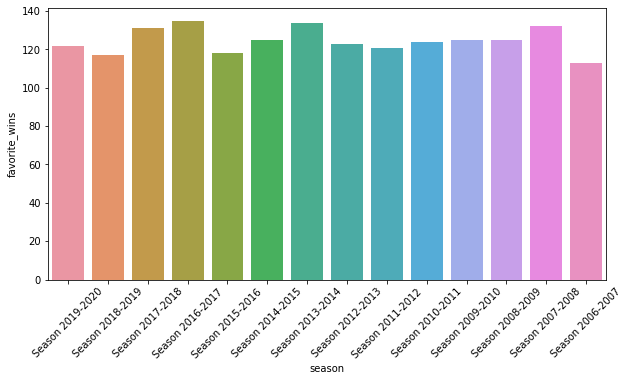

In [28]:
#Lets graph a bar chart of favorite to win vs underdogs to win vs games that pushed



fig, ax = plt.subplots(figsize=(10,5))


favorite_wins_per_season = sns.barplot(x=df_season_records['season'], y=df_season_records['favorite_wins'])



favorite_wins_per_season.set_xticklabels(favorite_wins_per_season.get_xticklabels(), rotation=45)



plt.show()

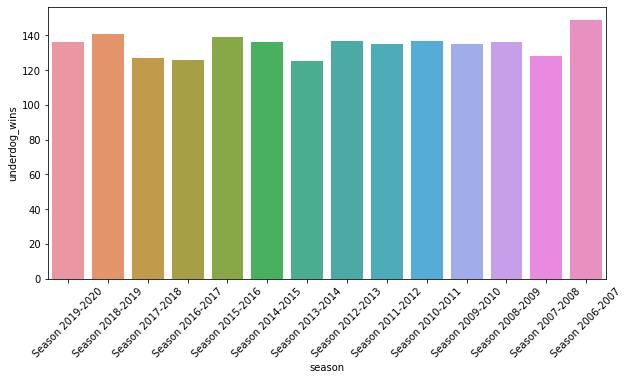

In [29]:
fig, ax = plt.subplots(figsize=(10,5))

underdog_wins_per_season = sns.barplot(x=df_season_records['season'], y=df_season_records['underdog_wins'])

underdog_wins_per_season.set_xticklabels(underdog_wins_per_season.get_xticklabels(), rotation=45)

plt.show()

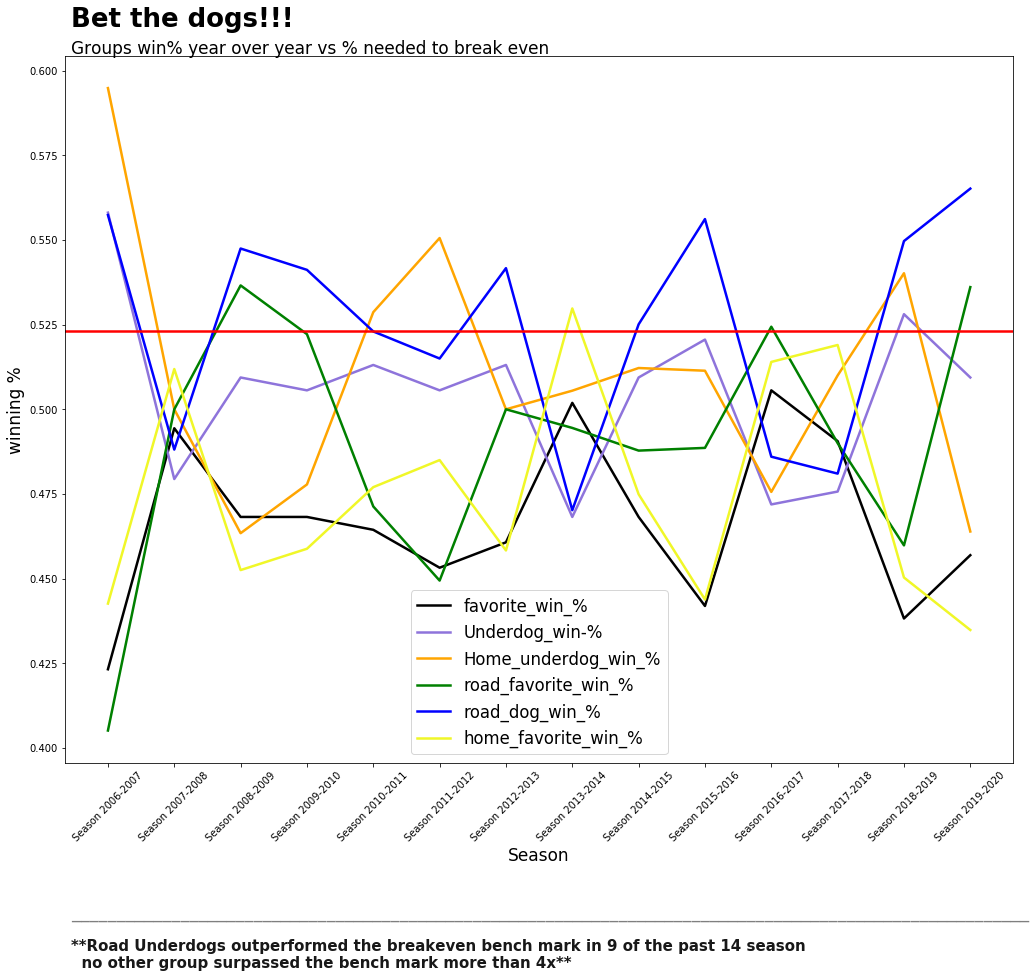

In [30]:
## Make line graph to show trends

## add totals to home favorites wins/home underdog wins/ road favorites/road underdog totals

fig, ax = plt.subplots(figsize=(17,13))

# sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


#Favorite Win % line
sns.lineplot(x=df_season_records['season'], y=df_season_records['favorite_win_%'],
                              color='black', ax=ax, label='favorite_win_%')

# #underdog win % line
sns.lineplot(x=df_season_records['season'], y=df_season_records['underdog_win_%'],
                              color='#8e74db', ax=ax, label='Underdog_win-%')

# #home underdog win % line
sns.lineplot(x=df_season_records['season'], y=df_season_records['home_dog_win_%'],
                              color='orange', ax=ax, label='Home_underdog_win_%')


#road favorite win % line
sns.lineplot(x=df_season_records['season'], y=df_season_records['road_favorite_win_%'],
                              color='g', ax=ax, label='road_favorite_win_%')

#road underdog win % line
sns.lineplot(x=df_season_records['season'], y=df_season_records['road_dog_win_%'],
                              color='b', ax=ax, label='road_dog_win_%')

# #home favorite win % line
sns.lineplot(x=df_season_records['season'], y=df_season_records['home_favorite_win_%'],
                              color='#f0f728', ax=ax, label='home_favorite_win_%')



ax.set_xlabel('Season', fontsize=17)
ax.set_ylabel('winning %', fontsize=17)
plt.xticks(rotation=45)

## Lets add text to make a title for our graph
ax.text(x=-.55, y=.613, s='Bet the dogs!!!', fontweight='bold', fontsize=26)

## Add a subtitle for context
ax.text(x=-.55, y=.605, s='Groups win% year over year vs % needed to break even',  fontsize=17)

#Plot horizontal line showing the break even point
plt.axhline(.523, color='red', label='Break_even_%')

#add footer
ax.text(s='_'*105, x=-.55, y=.35, alpha=.5)
ax.text(s='**Road Underdogs outperformed the breakeven bench mark in 9 of the past 14 season \n  no other group surpassed the bench mark more than 4x**', fontweight='bold', x=-.55, y=0.335, fontsize=15, alpha=.9)

plt.show()

ax.grid()

plt.show()

###Feature Engineer on the Total Score Subset of Data

Add column show the total combined score of each game

Add column showing whether the total combined score was over, under, or pushed what the bookie 


In [31]:
## If the sum of the home and away scores is greater than the 'total score close' then the over hit
## If the sum of the home and away scores is less than the 'total score close' then the under hit
## If the sum of the home and away scores is equal to the 'total score close then the total pushes

## Add column that shows the total combined score of the game. 

df_cleaned_Score_Totals['final_total_score'] = df_cleaned_Score_Totals['Home Score'] + df_cleaned_Score_Totals['Away Score']

df_cleaned_Score_Totals

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Total Score Open,Total Score Close,Season,final_total_score
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,53.0,53.0,Season 2019-2020,51
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,45.0,46.5,Season 2019-2020,57
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,51.0,51.0,Season 2019-2020,59
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,46.0,45.5,Season 2019-2020,51
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,49.5,50.5,Season 2019-2020,82
...,...,...,...,...,...,...,...,...,...,...,...,...
3733,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,44.0,44.0,Season 2006-2007,15
3734,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,36.5,36.5,Season 2006-2007,33
3735,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,38.5,38.5,Season 2006-2007,26
3736,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,43.5,43.5,Season 2006-2007,61


In [32]:
df_cleaned_Score_Totals.loc[df_cleaned_Score_Totals['final_total_score'] > df_cleaned_Score_Totals['Total Score Close'], 'over_hits'] = 1
df_cleaned_Score_Totals.loc[df_cleaned_Score_Totals['final_total_score'] < df_cleaned_Score_Totals['Total Score Close'], 'over_hits'] = 0

df_cleaned_Score_Totals.loc[df_cleaned_Score_Totals['final_total_score'] > df_cleaned_Score_Totals['Total Score Close'], 'under_hits'] = 0
df_cleaned_Score_Totals.loc[df_cleaned_Score_Totals['final_total_score'] < df_cleaned_Score_Totals['Total Score Close'], 'under_hits'] = 1

df_cleaned_Score_Totals.loc[df_cleaned_Score_Totals['final_total_score'] == df_cleaned_Score_Totals['Total Score Close'], 'game_pushes'] = 1
df_cleaned_Score_Totals.loc[df_cleaned_Score_Totals['final_total_score'] != df_cleaned_Score_Totals['Total Score Close'], 'game_pushes'] = 0

df_cleaned_Score_Totals

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Total Score Open,Total Score Close,Season,final_total_score,over_hits,under_hits,game_pushes
0,2020-02-02,Kansas City Chiefs,San Francisco 49ers,31,20,N,Y,Y,53.0,53.0,Season 2019-2020,51,0.0,1.0,0.0
1,2020-01-19,San Francisco 49ers,Green Bay Packers,37,20,N,Y,N,45.0,46.5,Season 2019-2020,57,1.0,0.0,0.0
2,2020-01-19,Kansas City Chiefs,Tennessee Titans,35,24,N,Y,N,51.0,51.0,Season 2019-2020,59,1.0,0.0,0.0
3,2020-01-12,Green Bay Packers,Seattle Seahawks,28,23,N,Y,N,46.0,45.5,Season 2019-2020,51,1.0,0.0,0.0
4,2020-01-12,Kansas City Chiefs,Houston Texans,51,31,N,Y,N,49.5,50.5,Season 2019-2020,82,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,44.0,44.0,Season 2006-2007,15,0.0,1.0,0.0
3734,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,36.5,36.5,Season 2006-2007,33,0.0,1.0,0.0
3735,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,38.5,38.5,Season 2006-2007,26,0.0,1.0,0.0
3736,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,43.5,43.5,Season 2006-2007,61,1.0,0.0,0.0


In [33]:
((df_cleaned_Score_Totals['Total Score Close'] == 53) & (df_cleaned_Score_Totals['over_hits'] == 1)).value_counts()[1]

7

In [34]:
## describe function on just the final total score

print(df_cleaned_Score_Totals['final_total_score'].describe())

df_cleaned_Score_Totals['Total Score Close'].value_counts()

count    3738.000000
mean       44.706795
std        14.060467
min         3.000000
25%        35.000000
50%        44.000000
75%        53.000000
max       105.000000
Name: final_total_score, dtype: float64


43.5    198
43.0    173
41.0    171
44.5    164
45.0    163
46.5    162
44.0    161
47.0    154
41.5    146
45.5    143
42.0    140
47.5    124
42.5    123
40.5    116
48.0    113
46.0    112
48.5    110
40.0    106
39.0     81
37.0     80
38.0     78
39.5     77
49.0     76
37.5     73
38.5     68
49.5     64
51.0     56
50.0     56
50.5     48
36.5     38
51.5     32
52.0     28
36.0     27
53.5     27
52.5     26
35.5     24
34.5     21
54.0     20
53.0     20
54.5     19
35.0     17
55.0     16
34.0     15
33.5     14
55.5     13
57.0      8
56.0      7
33.0      6
56.5      4
32.0      4
58.5      3
57.5      3
59.5      2
59.0      2
32.5      1
61.5      1
31.5      1
31.0      1
62.5      1
58.0      1
Name: Total Score Close, dtype: int64

In [35]:
print(df_cleaned_Score_Totals['Total Score Close'].describe())

df_cleaned_Score_Totals['Total Score Close'].value_counts()

count    3738.000000
mean       44.108347
std         4.582594
min        31.000000
25%        41.000000
50%        44.000000
75%        47.000000
max        62.500000
Name: Total Score Close, dtype: float64


43.5    198
43.0    173
41.0    171
44.5    164
45.0    163
46.5    162
44.0    161
47.0    154
41.5    146
45.5    143
42.0    140
47.5    124
42.5    123
40.5    116
48.0    113
46.0    112
48.5    110
40.0    106
39.0     81
37.0     80
38.0     78
39.5     77
49.0     76
37.5     73
38.5     68
49.5     64
51.0     56
50.0     56
50.5     48
36.5     38
51.5     32
52.0     28
36.0     27
53.5     27
52.5     26
35.5     24
34.5     21
54.0     20
53.0     20
54.5     19
35.0     17
55.0     16
34.0     15
33.5     14
55.5     13
57.0      8
56.0      7
33.0      6
56.5      4
32.0      4
58.5      3
57.5      3
59.5      2
59.0      2
32.5      1
61.5      1
31.5      1
31.0      1
62.5      1
58.0      1
Name: Total Score Close, dtype: int64

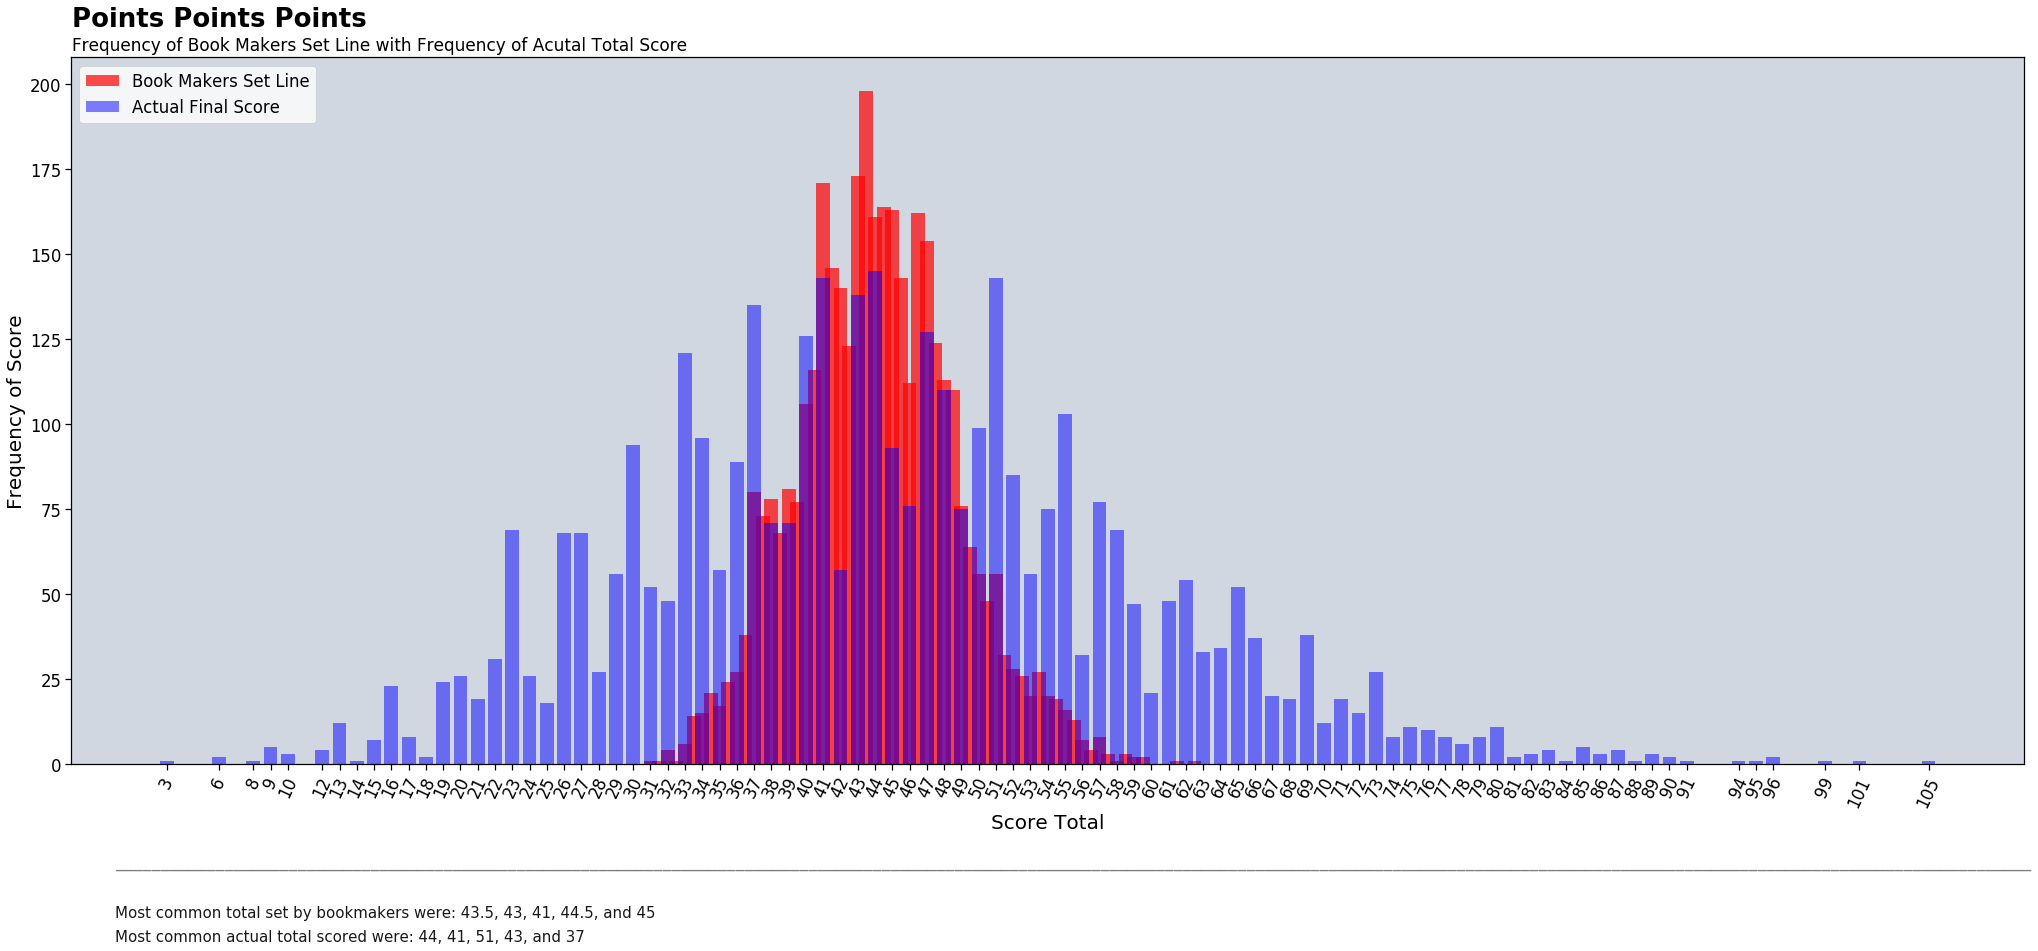

In [36]:
## Plotting the frequency of bookmakers Set Lines against the frequency of actual total scores

fig1, ax1 = plt.subplots(figsize=(35,13))

##plot for the most frequent SET total score of game

total_scores_bookie = np.array([df_cleaned_Score_Totals['Total Score Close']])
labels_bookie, counts_bookie = np.unique(total_scores_bookie, return_counts=True)
plt.bar(labels_bookie, counts_bookie, align='center', color='r', alpha=.7)



##plot for the most frequent ACTUAL total score of game

total_scores = np.array([df_cleaned_Score_Totals['final_total_score']])


labels, counts = np.unique(total_scores, return_counts=True)
plt.bar(labels, counts, align='center', color='b', alpha=.5)
plt.gca().set_xticks(labels)
ax1.set_xlabel('Score Total', fontsize=20)
ax1.set_ylabel('Frequency of Score', fontsize=20)
ax1.legend(['Book Makers Set Line', 'Actual Final Score'], loc=2)
ax1.set_facecolor('#d1d7e0')
plt.xticks(rotation=65)
## Lets add text to make a title for our graph

ax1.text(x=-2.5, y=217, s='Points Points Points', fontweight='bold', fontsize=26)

## Add a subtitle for context
ax1.text(x=-2.5, y=210, s='Frequency of Book Makers Set Line with Frequency of Acutal Total Score',  fontsize=17)

#add footer
ax1.text(s='___'*70, x=0, y=-30, alpha=.5)
ax1.text(s='Most common total set by bookmakers were: 43.5, 43, 41, 44.5, and 45',  x=0, y=-45, fontsize=15, alpha=.9)
ax1.text(s='Most common actual total scored were: 44, 41, 51, 43, and 37',  x=0, y=-52, fontsize=15, alpha=.9)

plt.show()

### Create another prettier data frame to show total overs and under by season

In [0]:
seasons = df_cleaned_Score_Totals['Season'].unique()
empty_list = []

for season in seasons:
  temp = pd.DataFrame({'season': [season],
   'over_hits': [((df_cleaned_Score_Totals['over_hits'] == 1) & (df_cleaned_Score_Totals['Season'] == season)).value_counts()[1]],
   'under_hits': [((df_cleaned_Score_Totals['under_hits'] == 1) & (df_cleaned_Score_Totals['Season'] == season)).value_counts()[1]],
   'total_pushed': [((df_cleaned_Score_Totals['game_pushes'] == 1) & (df_cleaned_Score_Totals['Season'] == season)).value_counts().sum() - ((df_cleaned_Score_Totals['game_pushes'] == 1) & (df_cleaned_Score_Totals['Season'] == season)).value_counts()[0]],
   'average_ppg': [round((df_cleaned_Score_Totals['final_total_score'].where(df_cleaned_Score_Totals['Season'] == season).sum() / (df_cleaned_Score_Totals['final_total_score'].where(df_cleaned_Score_Totals['Season'] == season).value_counts().sum())), 2)]})
  empty_list.append(temp)

df_season_over_under_records = pd.concat(empty_list, join='outer')

df_season_over_under_records['Total Games'] = df_season_over_under_records['over_hits'] + df_season_over_under_records['under_hits'] + df_season_over_under_records['total_pushed']

In [38]:
df_season_over_under_records['over_hits_percentage'] = round(df_season_over_under_records['over_hits'] / df_season_over_under_records['Total Games'] * 100, 2)
df_season_over_under_records['under_hits_percentage'] = round(df_season_over_under_records['under_hits'] / df_season_over_under_records['Total Games'] * 100, 2)
df_season_over_under_records['push_percentage'] = round(df_season_over_under_records['total_pushed'] / df_season_over_under_records['Total Games'] * 100, 2)



df_season_over_under_records.set_index('season')



,over_hits,under_hits,total_pushed,average_ppg,Total Games,over_hits_percentage,under_hits_percentage,push_percentage
season,,,,,,,,
Season 2019-2020,132,133,2,45.70,267,49.44,49.81,0.75
Season 2018-2019,124,140,3,46.55,267,46.44,52.43,1.12
Season 2017-2018,125,142,0,43.63,267,46.82,53.18,0.00
Season 2016-2017,142,123,2,45.74,267,53.18,46.07,0.75
Season 2015-2016,124,138,5,45.46,267,46.44,51.69,1.87
Season 2014-2015,124,140,3,45.27,267,46.44,52.43,1.12
Season 2013-2014,134,127,6,46.87,267,50.19,47.57,2.25
Season 2012-2013,131,132,4,45.78,267,49.06,49.44,1.50
Season 2011-2012,132,132,3,44.49,267,49.44,49.44,1.12


In [39]:
## Get sorted by over hits percentage

test = pd.DataFrame(df_season_over_under_records[['season', 'over_hits_percentage', 'under_hits_percentage', 'push_percentage' ]])
test.sort_values(['over_hits_percentage'], ascending=False)

,season,over_hits_percentage,under_hits_percentage,push_percentage
0,Season 2010-2011,55.06,43.82,1.12
0,Season 2016-2017,53.18,46.07,0.75
0,Season 2007-2008,52.81,45.32,1.87
0,Season 2013-2014,50.19,47.57,2.25
0,Season 2019-2020,49.44,49.81,0.75
0,Season 2011-2012,49.44,49.44,1.12
0,Season 2012-2013,49.06,49.44,1.50
0,Season 2006-2007,48.31,47.94,3.75
0,Season 2008-2009,47.94,49.06,3.00
0,Season 2009-2010,47.19,51.69,1.12


In [0]:

#Lets group totals to see how often a line hit over or under on specific line set by bookie

totals = df_cleaned_Score_Totals['Total Score Close'].unique()
empty_list = []

for total in totals:
  temp = pd.DataFrame({'final_score_close': [total],
                       'over_hits': [((df_cleaned_Score_Totals['Total Score Close'] == total) & (df_cleaned_Score_Totals['over_hits'] == 1)).value_counts().sum() - ((df_cleaned_Score_Totals['Total Score Close'] == total) & (df_cleaned_Score_Totals['over_hits'] == 1)).value_counts()[0]],
                       'under_hits': [((df_cleaned_Score_Totals['Total Score Close'] == total) & (df_cleaned_Score_Totals['under_hits'] == 1)).value_counts().sum() - ((df_cleaned_Score_Totals['Total Score Close'] == total) & (df_cleaned_Score_Totals['under_hits'] == 1)).value_counts()[0]],
                       'game_is_push': [((df_cleaned_Score_Totals['Total Score Close'] == total) & (df_cleaned_Score_Totals['game_pushes'] == 1)).value_counts().sum() - ((df_cleaned_Score_Totals['Total Score Close'] == total) & (df_cleaned_Score_Totals['game_pushes'] == 1)).value_counts()[0]]
                       
                       })
  empty_list.append(temp)

df_over_under_by_score = pd.concat(empty_list, join='outer')


##New column to show the total games at that specific score
df_over_under_by_score['Total Games'] = df_over_under_by_score['over_hits'] + df_over_under_by_score['under_hits'] + df_over_under_by_score['game_is_push']



In [41]:
df_over_under_by_score.head()

,final_score_close,over_hits,under_hits,game_is_push,Total Games
0,53.0,7,11,2,20
0,46.5,85,77,0,162
0,51.0,27,28,1,56
0,45.5,63,80,0,143
0,50.5,23,25,0,48


In [42]:
## Now that we have those totals we want to add the percent that the over hits

df_over_under_by_score['over_hits_percentage'] = df_over_under_by_score['over_hits'] / df_over_under_by_score['Total Games'] * 100
df_over_under_by_score['under_hits_percentage'] = df_over_under_by_score['under_hits'] / df_over_under_by_score['Total Games'] * 100
df_over_under_by_score['push_percentage'] = df_over_under_by_score['game_is_push'] / df_over_under_by_score['Total Games'] * 100

df_over_under_by_score.sort_values(['over_hits_percentage', 'Total Games'], ascending=False).head(26)



,final_score_close,over_hits,under_hits,game_is_push,Total Games,over_hits_percentage,under_hits_percentage,push_percentage
0,32.0,4,0,0,4,100.000000,0.000000,0.000000
0,59.0,2,0,0,2,100.000000,0.000000,0.000000
0,59.5,2,0,0,2,100.000000,0.000000,0.000000
0,62.5,1,0,0,1,100.000000,0.000000,0.000000
0,58.0,1,0,0,1,100.000000,0.000000,0.000000
0,32.5,1,0,0,1,100.000000,0.000000,0.000000
0,35.0,12,4,1,17,70.588235,23.529412,5.882353
0,35.5,16,8,0,24,66.666667,33.333333,0.000000
0,58.5,2,1,0,3,66.666667,33.333333,0.000000
0,53.5,17,10,0,27,62.962963,37.037037,0.000000


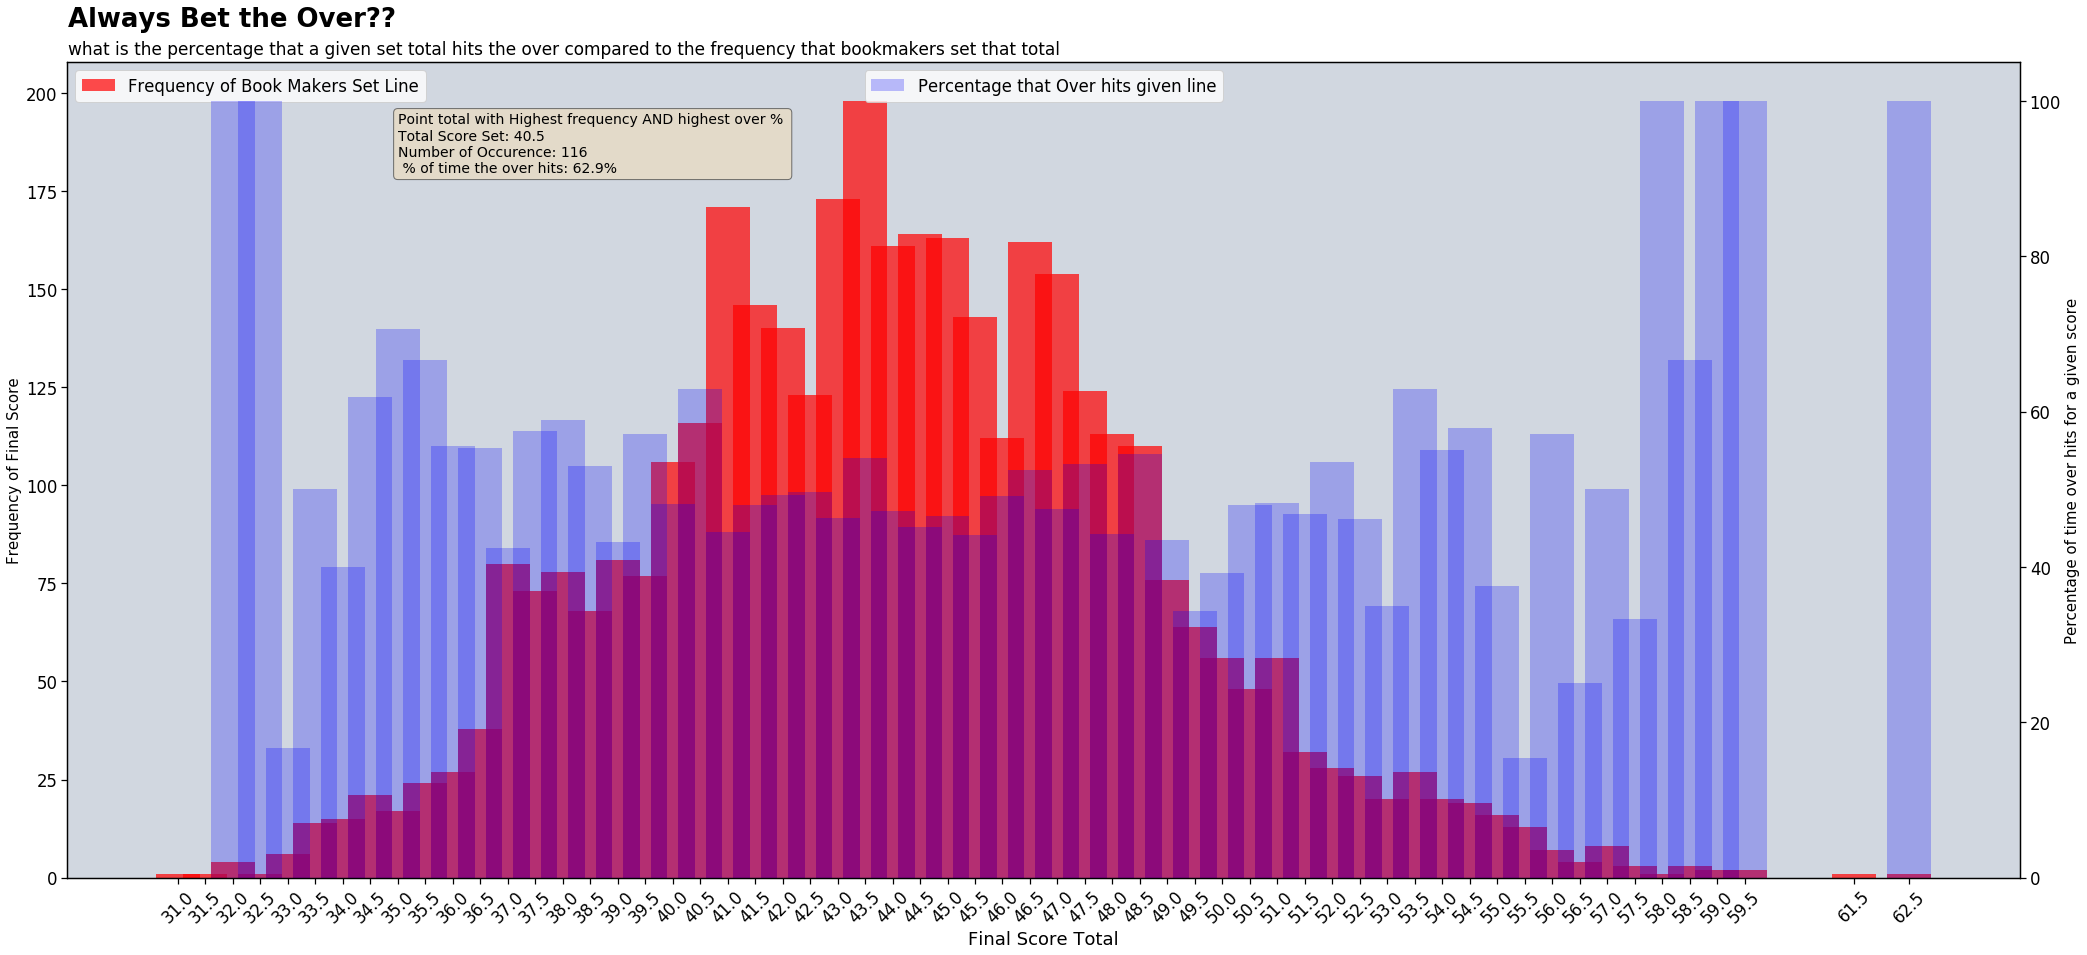

In [43]:
fig, ax = plt.subplots(figsize=(35,15))



##plot for the most frequent SET total score of game
total_scores_bookie = np.array([df_cleaned_Score_Totals['Total Score Close']])
labels_bookie, counts_bookie = np.unique(total_scores_bookie, return_counts=True)
plt.bar(labels_bookie, counts_bookie, align='center', color='r', alpha=.7)

#set the xticks
plt.gca().set_xticks(labels_bookie)
plt.xticks(rotation=45)


#Set titles for labels
ax.set_xlabel('Final Score Total')
ax.set_ylabel('Frequency of Final Score', fontsize=15)


## Plot the percentage of times the over hits for a specific socre.

#create a second axes so we can show percentage on a dual Y axis
ax2 = ax.twinx()

#plot percentage of time over hits a specific score
ax2.bar(df_over_under_by_score['final_score_close'], df_over_under_by_score['over_hits_percentage'], align='center', color='b', alpha=.25)
ax2.set_ylabel('Percentage of time over hits for a given score', fontsize=15)

## Add legends to show which color bars are which plot. 
ax.legend(['Frequency of Book Makers Set Line'], loc=2)
ax2.legend(['Percentage that Over hits given line'])

#Add Text to show the best outcome spot to bet

text = ('Point total with Highest frequency AND highest over % \n'
    'Total Score Set: 40.5 \n' 
'Number of Occurence: 116 \n'
' % of time the over hits: 62.9%')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.text(35, 195, text, bbox=props, verticalalignment='top', fontsize=14)


## Lets add text to make a title for our graph

ax.text(x=29, y=217, s='Always Bet the Over??', fontweight='bold', fontsize=26)

## Add a subtitle for context
ax.text(x=29, y=210, s='what is the percentage that a given set total hits the over compared to the frequency that bookmakers set that total',  fontsize=17)



## set figure and axes colors
ax.set_facecolor(color='#d1d7e0')




plt.show()
